In [39]:
import math

class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self.backward = lambda: None
        self._prev = set(_children)
        self.op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # to make a+1 possible 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        # to make a*1 possible 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward

        return out

    # to do other * self
    def __rmul__(self, other): 
        return self * other

    # to do self / other
    def __truediv__(self, other): 
        return self * other**-1

    # for subtracting 
    def __neg__(self):
        return self*-1

    # to do subtraction
    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1-t**2) * out.grad
        out._backward = _backward
        
        return out

    # to do a.exp() 
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [34]:
a = Value(2.0)
a+1

Value(data=3.0)

but python can't do 2*a 
because 2.__mul__(a) can't be done.
So, let's define __rmul__ function above.

In [26]:
a = Value(2.0)
2*a

Value(data=4.0)

Let's add exp function above to make a.exp() possible

In [35]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

Let's make division function

a / b
a * (1/b)
a * (b**-1)

Use __turediv__ func and __pow__ func

In [41]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

Let's make subtraction function

In [42]:
a - b

Value(data=-2.0)

In [11]:
from graphviz import Digraph
from micrograd.engine import Value
from IPython.display import display

In [12]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n.op:  # Changed from n._op to n.op
            dot.node(name=uid + n.op, label=n.op)  # Consistent use of n.op
            # And connect this node to it
            dot.edge(uid + n.op, uid)  # Consistent use of n.op
    
    for n1, n2 in edges:
        # Connect n1 to the operation node of n2
        if n2.op:  # Added a check for existence and changed from n2._op to n2.op
            dot.edge(str(id(n1)), str(id(n2)) + n2.op)  # Consistent use of n2.op
    
    return dot

In [46]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x1*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()

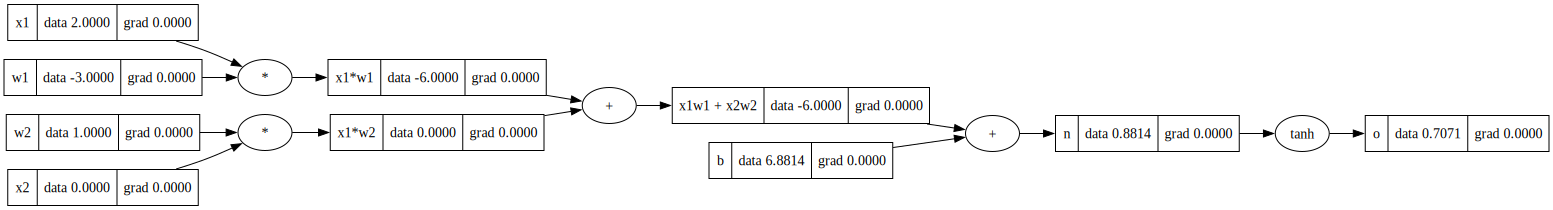

In [47]:
draw_dot(o)

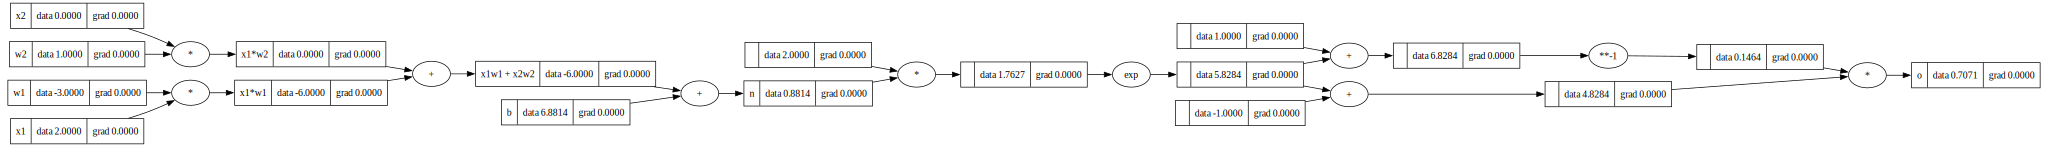

In [45]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x1*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e-1)/(e+1)

o.label = 'o'
o.backward()
draw_dot(o)